In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.linalg as la

from data import *
from models import train

# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


# Data generation functions

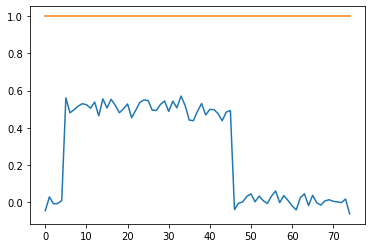

In [2]:
u, y = single_decision(16*3.2/100)
plt.plot(u)
plt.plot(y)

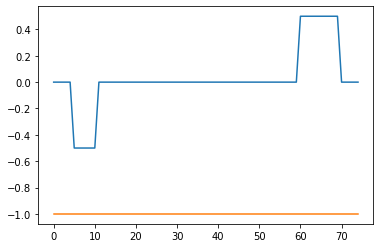

In [3]:
u, y = parametric(10, 34)
plt.plot(u)
plt.plot(y)

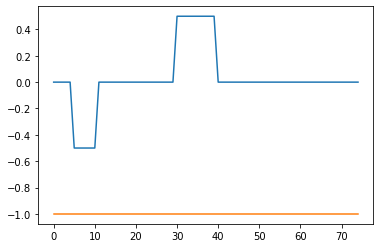

In [33]:
u, y = parametric(10, 34, pause=20)
plt.plot(u)
plt.plot(y)

# RNN Class

In [4]:
class RNN(nn.Module):

    def __init__(self, network_size=128,rank=1):

        super(RNN, self).__init__()
        self.network_size = network_size
        self.rank=rank

        # Weight initialization
        #unit rank rnn weight matrix J=mn^T/n
#         if rank==1:
        self.m = nn.Parameter(torch.Tensor(network_size, rank))
        self.n = nn.Parameter(torch.Tensor(network_size, rank))
        self.wi = torch.Tensor(network_size)
        self.w = torch.Tensor(network_size, 1)
        self.x0= torch.Tensor(network_size, 1)
#         else:
#             self.m = nn.Parameter(torch.Tensor(self.network_size,self.rank))
#             self.n = nn.Parameter(torch.Tensor(self.network_size,self.rank))
#             self.wi = torch.Tensor(self.network_size,1)
#             self.w = torch.Tensor(self.network_size,1)
#             self.x0= torch.Tensor(self.network_size,1)

                # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()

        with torch.no_grad():
            self.m.normal_(std=1)
            self.n.normal_(std=1)
            self.w.normal_(std=4)
            self.x0.zero_()
            self.wi.normal_(std=1)

    def forward(self, u, visible_activity=False):
        
        # print(u)
        if len(u.shape) == 1:
            u = u.unsqueeze(0)
            
            
            
        input_len=u.size(1)
        batch_size=u.size(0)
        
        x = torch.zeros(batch_size, self.network_size)
        z = torch.zeros(u.shape)

        r = self.activation(x)

        if visible_activity:
            unit_activity = torch.zeros(batch_size, input_len+1, self.network_size)
            unit_activity[:,0,:] = x

        for i in range(input_len):
            delta_x = (
                -x
                + r.matmul(self.n).matmul(self.m.t()) / self.network_size
                + torch.outer(u[:,i], self.wi.squeeze())
            ) * (self.dt / self.tau)

            x = x + delta_x
            r = self.activation(x)
            if visible_activity:
                unit_activity[:,i+1,:] = x

            output = torch.matmul(r, self.w) / self.network_size
            z[:, i] = output.squeeze()

        if visible_activity:
            return z, unit_activity
        else:
            return z

# Rank-One Tests

In [5]:
sd_single_data = SingleDecisionDataset(1)
train_dataloader = DataLoader(sd_single_data, batch_size=1)
model = RNN()
train(train_dataloader, model, device)

loss: 1.009936  [    1/    1]


In [6]:
sd_single_data = SingleDecisionDataset(5)
train_dataloader = DataLoader(sd_single_data, batch_size=5)
model = RNN()
train(train_dataloader, model, device)

loss: 0.992655  [    5/    5]


In [7]:
sd_dataset = SingleDecisionDataset(8000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN()
train(train_dataloader, model, device)

loss: 1.001041  [   32/ 8000]
loss: 0.716149  [ 3232/ 8000]
loss: 0.000928  [ 6432/ 8000]


torch.Size([75])
(1, 76, 128)


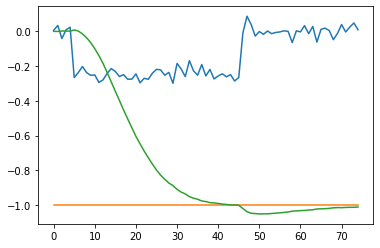

In [8]:
strength = -8
u, y = single_decision(strength*3.2/100)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)


# Full rank single_decision

In [24]:
sd_dataset = SingleDecisionDataset(8000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN(rank=128)
train(train_dataloader, model, device)

loss: 1.084367  [   32/ 8000]
loss: 0.000051  [ 3232/ 8000]
loss: 0.000019  [ 6432/ 8000]


torch.Size([75])
(1, 76, 128)


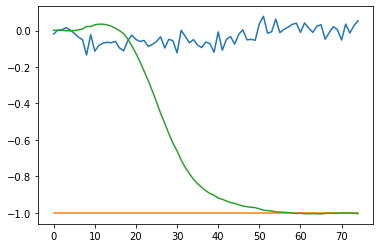

In [27]:
strength = -2
u, y = single_decision(strength*3.2/100)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

# Rank 2 Parametric

In [9]:
p_data = ParametricDataset(1)
train_dataloader = DataLoader(p_data, batch_size=1)
model = RNN(rank=2)
train(train_dataloader, model, device)


loss: 0.052848  [    1/    1]


In [10]:
p_data = ParametricDataset(5)
train_dataloader = DataLoader(p_data, batch_size=5)
model = RNN(rank=2)
train(train_dataloader, model, device)

loss: 0.257612  [    5/    5]


### Rank 2 network overfits on 1 sample parametric dataset (GOOD!)

In [29]:
p_data = ParametricDataset(1)
train_dataloader = DataLoader(p_data, batch_size=1)
model = RNN(rank=2)

for _ in range(200):
    train(train_dataloader, model, device, T=5)

loss: 0.505674  [    1/    1]
loss: 0.504746  [    1/    1]
loss: 0.503820  [    1/    1]
loss: 0.502896  [    1/    1]
loss: 0.501973  [    1/    1]
loss: 0.501052  [    1/    1]
loss: 0.500132  [    1/    1]
loss: 0.499213  [    1/    1]
loss: 0.498244  [    1/    1]
loss: 0.497217  [    1/    1]
loss: 0.496134  [    1/    1]
loss: 0.494994  [    1/    1]
loss: 0.493797  [    1/    1]
loss: 0.492543  [    1/    1]
loss: 0.491233  [    1/    1]
loss: 0.489867  [    1/    1]
loss: 0.488445  [    1/    1]
loss: 0.486967  [    1/    1]
loss: 0.485433  [    1/    1]
loss: 0.483843  [    1/    1]
loss: 0.482198  [    1/    1]
loss: 0.480498  [    1/    1]
loss: 0.478742  [    1/    1]
loss: 0.476932  [    1/    1]
loss: 0.475068  [    1/    1]
loss: 0.473149  [    1/    1]
loss: 0.471176  [    1/    1]
loss: 0.469149  [    1/    1]
loss: 0.467068  [    1/    1]
loss: 0.464934  [    1/    1]
loss: 0.462747  [    1/    1]
loss: 0.460508  [    1/    1]
loss: 0.458216  [    1/    1]
loss: 0.45

In [34]:
p_data = ParametricDataset(32000)
train_dataloader = DataLoader(p_data, batch_size=32)
model = RNN(rank=2)
train(train_dataloader, model, device, T=5)

loss: 0.238865  [   32/32000]
loss: 0.092928  [ 3232/32000]
loss: 0.130170  [ 6432/32000]
loss: 0.122584  [ 9632/32000]
loss: 0.108070  [12832/32000]
loss: 0.102900  [16032/32000]
loss: 0.108064  [19232/32000]
loss: 0.112366  [22432/32000]
loss: 0.071592  [25632/32000]
loss: 0.105483  [28832/32000]


torch.Size([75])
(1, 76, 128)


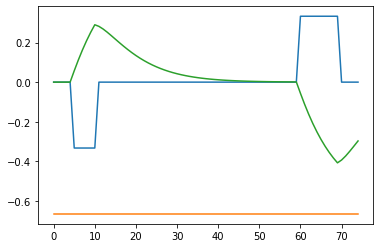

In [22]:
u, y = parametric(14, 30)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

In [30]:
pause_lengths = np.arange(25, 51, 5)
model = RNN(rank=2)

for pl in pause_lengths:
    p_data = ParametricDataset(6400, pause=pl)
    train_dataloader = DataLoader(p_data, batch_size=32)
    train(train_dataloader, model, device)
    

loss: 0.236368  [   32/ 6400]
loss: 0.157351  [ 3232/ 6400]
loss: 0.114686  [   32/ 6400]
loss: 0.123613  [ 3232/ 6400]
loss: 0.020687  [   32/ 6400]
loss: 0.006238  [ 3232/ 6400]
loss: 0.003482  [   32/ 6400]
loss: 0.004339  [ 3232/ 6400]
loss: 0.008086  [   32/ 6400]
loss: 0.004512  [ 3232/ 6400]
loss: 0.025328  [   32/ 6400]
loss: 0.025582  [ 3232/ 6400]


torch.Size([75])
(1, 76, 128)


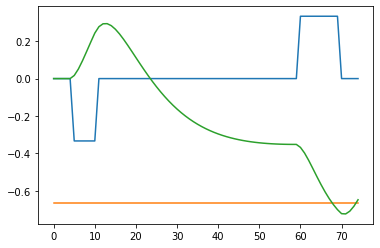

In [32]:
u, y = parametric(14, 30)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)